In [68]:
# Завантаження необхідних бібліотек і функцій
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [69]:
movie_ids = 'movie_ids.txt'
movies_mat = 'movies.mat'

In [70]:
def normalizeRatings(Y, R):
    m, n = Y.shape
    Ymean = np.zeros(m)
    Ynorm = np.zeros(Y.shape)

    for i in range(m):
        idx = R[i, :] == 1
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]

    return Ynorm, Ymean


def loadMovieList():
    with open(movie_ids,  encoding='ISO-8859-1') as fid:
        movies = fid.readlines()

    movieNames = []
    for movie in movies:
        parts = movie.split()
        movieNames.append(' '.join(parts[1:]).strip())
    return movieNames


def computeNumericalGradient(J, theta, e=1e-4):
    numgrad = np.zeros(theta.shape)
    perturb = np.diag(e * np.ones(theta.shape))
    for i in range(theta.size):
        loss1, _ = J(theta - perturb[:, i])
        loss2, _ = J(theta + perturb[:, i])
        numgrad[i] = (loss2 - loss1)/(2*e)
    return numgrad


def checkCostFunction(cofiCostFunc, lambda_=0.):

    X_t = np.random.rand(4, 3)
    Theta_t = np.random.rand(5, 3)


    Y = np.dot(X_t, Theta_t.T)
    Y[np.random.rand(*Y.shape) > 0.5] = 0
    R = np.zeros(Y.shape)
    R[Y != 0] = 1


    X = np.random.randn(*X_t.shape)
    Theta = np.random.randn(*Theta_t.shape)
    num_movies, num_users = Y.shape
    num_features = Theta_t.shape[1]

    params = np.concatenate([X.ravel(), Theta.ravel()])
    numgrad = computeNumericalGradient(
        lambda x: cofiCostFunc(x, Y, R, num_users, num_movies, num_features, lambda_), params)

    cost, grad = cofiCostFunc(params, Y, R, num_users,num_movies, num_features, lambda_)

    print(np.stack([numgrad, grad], axis=1))
    print('\nThe above two columns you get should be very similar.'
          '(Left-Your Numerical Gradient, Right-Analytical Gradient)')

    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad)
    print('If your cost function implementation is correct, then '
          'the relative difference will be small (less than 1e-9).')
    print('\nRelative Difference: %g' % diff)

In [71]:

movie_names = loadMovieList()

In [72]:
data = loadmat(movies_mat)
Y, R = data['Y'], data['R']

Average rating for movie 181 ( Return of the Jedi (1983) ): 2.685381 / 5


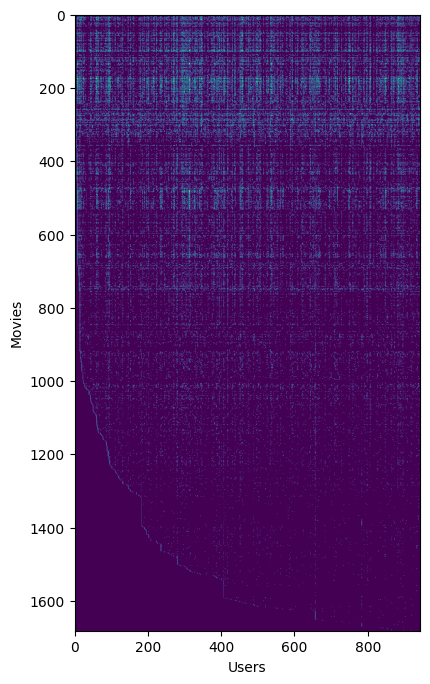

In [76]:
# Из матрицы мы можем вычислить статистику, например средний рейтинг.
print('Average rating for movie 181 (', movie_names[180] ,'): %f / 5' % np.mean(Y[180, R[180, :]]))

# Мы можем «визуализировать» матрицу рейтингов, построив ее с помощью imshow
plt.figure(figsize=(8, 8))
plt.imshow(Y)
plt.ylabel('Movies')
plt.xlabel('Users')
plt.grid(False)

In [51]:
def cofiCostFunc(params, Y, R, num_users, num_movies,
                      num_features, lambda_=0.0):
    # Разворачиваем матрицы U и W из параметров
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)


    # Вам необходимо правильно вернуть следующие значения
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    J = (1 / 2) * np.sum(np.square((X.dot(Theta.T) - Y) * R)) + (lambda_ / 2) * np.sum(np.square(X)) + \
                                                                (lambda_ / 2) * np.sum(np.square(Theta))

    for i in range(R.shape[0]):

        idx = np.where(R[i, :] == 1)[0]
        Theta_temp = Theta[idx, :]
        Y_temp = Y[i, idx]
        X_grad[i, :] = np.dot(np.dot(X[i, :], Theta_temp.T) - Y_temp, Theta_temp) + lambda_ * X[i, :]

    for j in range(R.shape[1]):

        idx = np.where(R[:, j] == 1)[0]
        X_temp = X[idx, :]
        Y_temp = Y[idx, j]
        Theta_grad[j, :] = np.dot(np.dot(X_temp, Theta[j, :]) - Y_temp, X_temp) + lambda_ * Theta[j, :]

    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    return J, grad

In [52]:
# Проверьте градиенты, запустив checkcostFunction
checkCostFunction(cofiCostFunc, 1.5)

[[ -2.17429868  -2.17429868]
 [  1.28184735   1.28184735]
 [  4.35861502   4.35861502]
 [  3.13978156   3.13978156]
 [ -1.21719618  -1.21719618]
 [  0.03557511   0.03557511]
 [  2.12441229   2.12441229]
 [  0.82022995   0.82022995]
 [ -3.01430057  -3.01430057]
 [-10.14835653 -10.14835653]
 [  0.61900763   0.61900763]
 [ -1.92072302  -1.92072302]
 [  8.54019825   8.54019825]
 [  2.70646214   2.70646214]
 [  2.51311883   2.51311883]
 [ -0.17266669  -0.17266669]
 [ -1.69376443  -1.69376443]
 [  3.95746122   3.95746122]
 [  0.87692886   0.87692886]
 [ -1.29954991  -1.29954991]
 [ -0.3597122   -0.3597122 ]
 [  3.37640698   3.37640698]
 [ -2.96835085  -2.96835085]
 [  1.24998016   1.24998016]
 [  2.757225     2.757225  ]
 [ -2.32455317  -2.32455317]
 [ -2.94027424  -2.94027424]]

The above two columns you get should be very similar.(Left-Your Numerical Gradient, Right-Analytical Gradient)
If your cost function implementation is correct, then the relative difference will be small (less than 1

In [53]:
movieList = loadMovieList()

#  Прежде чем мы научимся модели совместной фильтрации, мы сначала
#  добавьте оценки, соответствующие новому пользователю, которого мы только что наблюдали. Этот
#  часть кода также позволит вам поставить свои собственные оценки для
#  фильмы в нашем наборе данных!
n_m = len(movieList)
#  Инициализировать мои рейтинги
my_ratings = np.zeros(n_m)
# Мы выбрали несколько фильмов, которые нам понравились/не понравились, и рейтинги, которые мы поставили.
# дали следующие:
my_ratings[0] = 4
my_ratings[97] = 2
my_ratings[6] = 2
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[364] = 2
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 1
my_ratings[22] = 5
my_ratings[124] = 5
my_ratings[54] = 2

movies_id_list = [0, 97, 6, 11, 53, 63, 65, 68, 182, 225, 354]

for movie in movies_id_list:
  print(movieList[movie])

Toy Story (1995)
Silence of the Lambs, The (1991)
Twelve Monkeys (1995)
Usual Suspects, The (1995)
Outbreak (1995)
Shawshank Redemption, The (1994)
While You Were Sleeping (1995)
Forrest Gump (1994)
Alien (1979)
Die Hard 2 (1990)
Sphere (1998)


In [74]:
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize
# Добавляем собственные рейтинги в матрицу данных
Y = np.hstack([my_ratings[:, None], Y])
R = np.hstack([(my_ratings > 0)[:, None], R])

# Нормализовать рейтинги
Ynorm, Ymean = normalizeRatings(Y, R)

# Полезные значения
num_movies, num_users = Y.shape
num_features = 7

# Установите начальные параметры (Тета, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])

# Установите параметры для scipy.optimize.minimize
options = {'maxiter': 100}

# Установить регуляризацию
lambda_ = 10

res = minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                      num_movies, num_features, lambda_),
               initial_parameters,
               method='TNC',
               jac=True,
               options=options)
theta = res.x

# Розгорніть отриманий theta назад у X та Theta
X = theta[:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

<ipython-input-74-2ffa8f181009>:27: OptimizeWarning: Unknown solver options: maxiter
  res = minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,


In [1]:
# Дайте рекомендации, вычислив матрицу прогнозов
p = np.dot(X, Theta.T)
my_predictions = p[:, 0] + Ymean

movieList = loadMovieList()

ix = np.argsort(my_predictions)[::-1]

print('Top recommendations for you:')
print('----------------------------')
for i in range(15):
    j = ix[i]
    print('Predicting rating %.1f for movie %s' % (my_predictions[j], movieList[j]))

print('\nOriginal ratings provided:')
print('--------------------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s' % (my_ratings[i], movieList[i]))

NameError: ignored